Nama        : Jonathan Louis Guido 
NPM         : 220711660 
Kelompok SB : Transformers 
Topik       : Klasifikasi Kematangan Rambutan 
Arsitektur  : MobileNet


In [29]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [30]:
count = 0
dirs = os.listdir(r'D:\TUBES PMDPM\mobilenet\train_data')
for dir in dirs:
    files = list(os.listdir(r'D:\TUBES PMDPM\mobilenet\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Busuk Folder has 100 Images
Matang Folder has 100 Images
Mentah Folder has 100 Images
Images Folder has 300 Images


In [31]:
base_dir = r'D:\TUBES PMDPM\mobilenet\train_data'
img_size = 180
batch = 32
validation_split = 0.1

In [32]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 300 files belonging to 3 classes.


In [33]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Busuk', 'Matang', 'Mentah']


In [34]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 10
Train Images: 9
Validation Images: 1


In [35]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

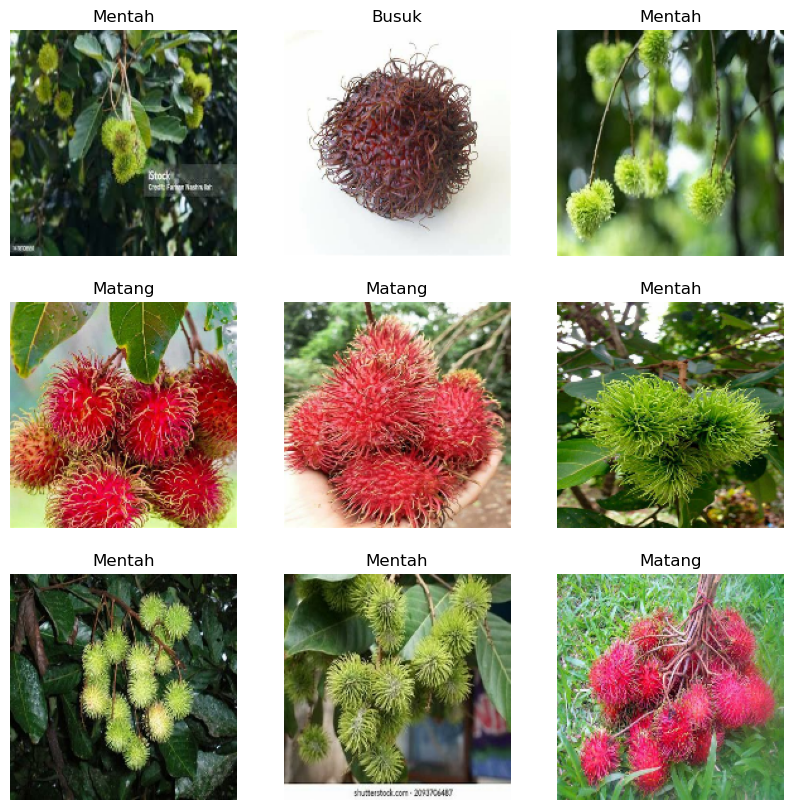

In [36]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [37]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 180, 180, 3)


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [40]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [41]:
data_augmentation = Sequential([
    layers.RandomFlip("diagonal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

d:\anaconda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


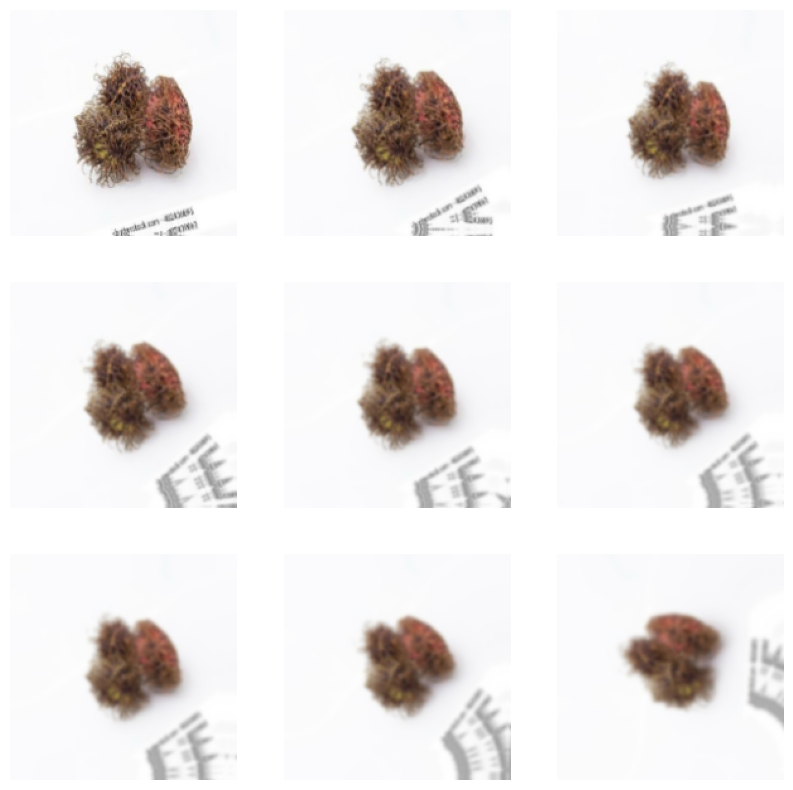

In [42]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet 


base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2
for layer in base_model. layers[:fine_tune_at]:
    layer.trainable = False 


model = Sequential([ 
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax' )
])

C:\Users\ACER\AppData\Local\Temp\ipykernel_13976\2888943737.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


In [44]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 3,069,443 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               mode='max')

history= model.fit(train_ds,
                   epochs=30,
                   validation_data=val_ds,
                   callbacks=[early_stopping])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4141 - loss: 1.3381 - val_accuracy: 0.5833 - val_loss: 1.2296
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8333 - loss: 0.4287 - val_accuracy: 0.5833 - val_loss: 0.5334
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9091 - loss: 0.2121 - val_accuracy: 0.8333 - val_loss: 0.2958
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9678 - loss: 0.1224 - val_accuracy: 0.8333 - val_loss: 0.2290
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9827 - loss: 0.0862 - val_accuracy: 0.9167 - val_loss: 0.1642
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9913 - loss: 0.0539 - val_accuracy: 0.9167 - val_loss: 0.1330
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9993 - loss: 0.0420 - val_accuracy: 1.0000 - val_loss: 0.0893
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9973 - loss: 0.0312 - val_accuracy: 1.0000 - val_loss: 0.0692
Epoch 9/30
9

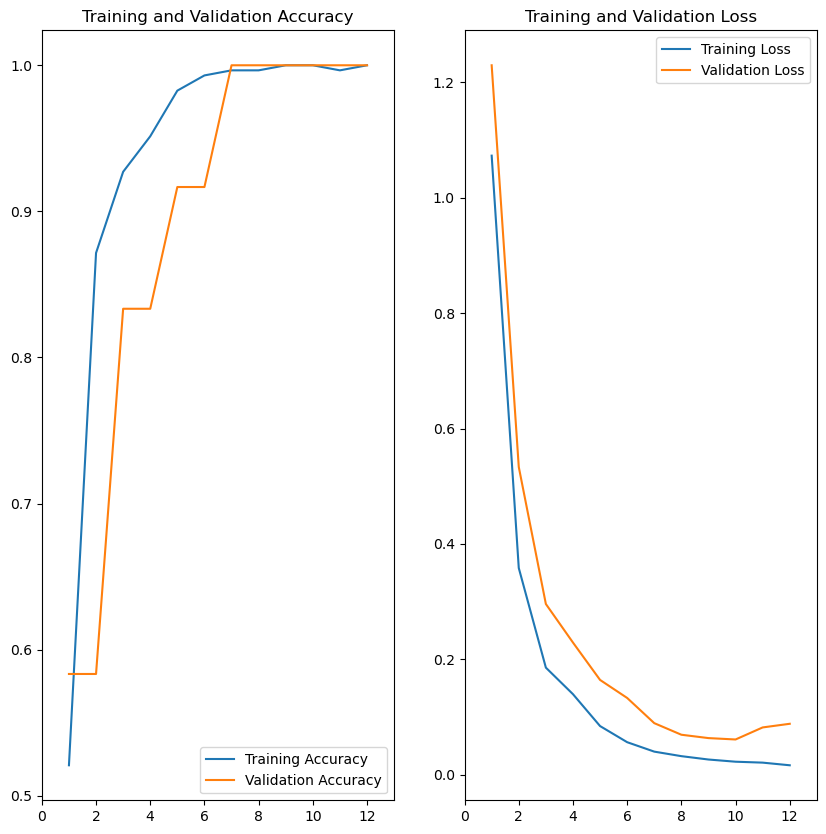

In [47]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [48]:
model.save('model_mobilenet.h5')

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

#memuat model yang sudah dilatih
model = load_model(r'D:\TUBES PMDPM\mobilenet\BestModel_MobileNet_Transformers.h5')
class_names = ['Busuk', 'Matang', 'Mentah']

#fungsi untuk mengklasifikasikan gambar dan menyimpan gambar asli
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        #memuat dan mempersiapkan gambar untuk prediksi
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0) 
                                                                    

        #melakukan prediksi
        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result) 
        confidence = np.max(result) * 100

        #menampilkan hasil prediksi dan confidence
        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        #menyimpan gambar asli tanpa teks
        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

#contoh penggunaan fungsi
result = classify_images(r'D:\TUBES PMDPM\mobilenet\test_data\Mentah\2.jpg', save_path='mentah.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi: Mentah
Confidence: 53.35%
Prediksi: Mentah dengan confidence 53.35%. Gambar asli disimpan di mentah.jpg.


Found 317 files belonging to 3 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 766ms/step


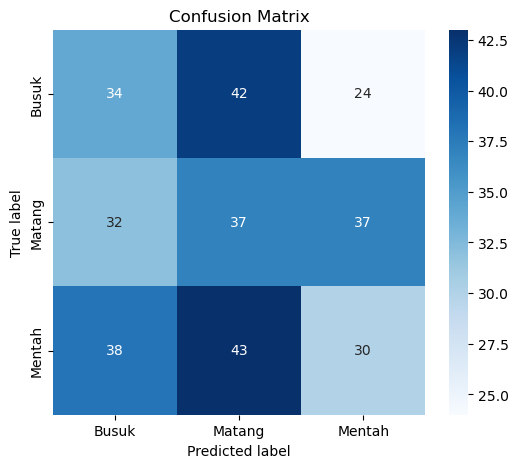

Confusion Matrix:
 [[34 42 24]
 [32 37 37]
 [38 43 30]]
Akurasi: 0.3186119873817035
Presisi: [0.32692308 0.30327869 0.32967033]
Recall: [0.34       0.3490566  0.27027027]
F1 Score: [0.33333333 0.3245614  0.2970297 ]


In [50]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'D:\TUBES PMDPM\mobilenet\BestModel_MobileNet_Transformers.h5')
class_names = ['Busuk', 'Matang', 'Mentah']

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(180, 180)
)

y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=["Busuk", "Matang", "Mentah"], yticklabels=["Busuk", "Matang", "Mentah"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())